# Load the data: the Cats vs Dogs dataset

In [1]:
import os

In [2]:
if os.path.exists('kagglecatsanddogs_5340.zip'):
    print('File already exist')
else:
    !wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

File already exist


In [3]:
if os.path.exists('PetImages'):
    print('File already exist')
else:
    !unzip -q kagglecatsanddogs_5340.zip

In [4]:
!ls PetImages

Cat  Dog


In [5]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
import os
# Configs
class CFG:
    #Random seed
    SEED = 42
    BASE = os.getcwd() +'/'
    early_stopping_patience = 20
    
    IMAGE_SIZE = (128,128)
    BATCH = 128
    LR = 0.00013
    epochs = 1000
    decey = LR/epochs
    H = 128
    W = 128
    CROP_H=128
    CROP_W=128
    model_name = "custom_classifier"

In [7]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras import backend as K

def set_seed(seed=42):
    # Set the Python hash seed
    os.environ['PYTHONHASHSEED']=str(seed)
    os.environ['TF_NUM_INTRAOP_THREADS'] = str(seed)
    # Set the Python, Numpy and Tensorflow random seeds
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.compat.v1.set_random_seed(seed)
    # Set deterministic options for Tensorflow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Limit Tensorflow to single thread for full reproducibility
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    print('seeding done!!!')
set_seed(CFG.SEED)


seeding done!!!


# Filter out corrupted images

In [8]:
# From git https://github.com/tensorflow/datasets/issues/2188 by eclarson
import os
import tensorflow as tf
from tensorflow.io import read_file, write_file
from tensorflow.image import decode_image

should_rewrite_image = True # set to true if you are getting Corrupt Data error
num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(CFG.BASE+'PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        is_jfif = True
        should_remove = False
        
        with open(fpath, "rb") as fobj:
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            
        try:
            img = read_file(fpath)
            if not tf.io.is_jpeg(img):
                should_remove = True
                
            img = decode_image(img)

            if img.ndim != 3:
                should_remove = True

        except Exception as e:
            should_remove = True
        
        if (not is_jfif) or should_remove:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        elif should_rewrite_image:
            tmp = tf.io.encode_jpeg(img)
            write_file(fpath, tmp)

print("Deleted %d images" % num_skipped)

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Deleted 1592 images


# Generate a Dataset

In [9]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=CFG.SEED,
    image_size=CFG.IMAGE_SIZE,
    batch_size=CFG.BATCH,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


# Visualize the data

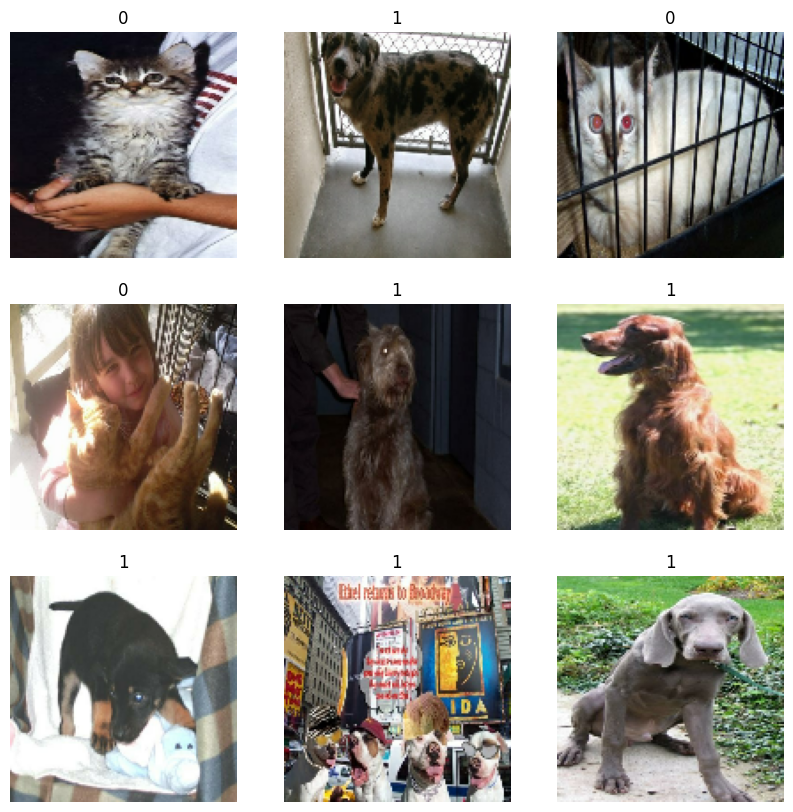

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation

In [11]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

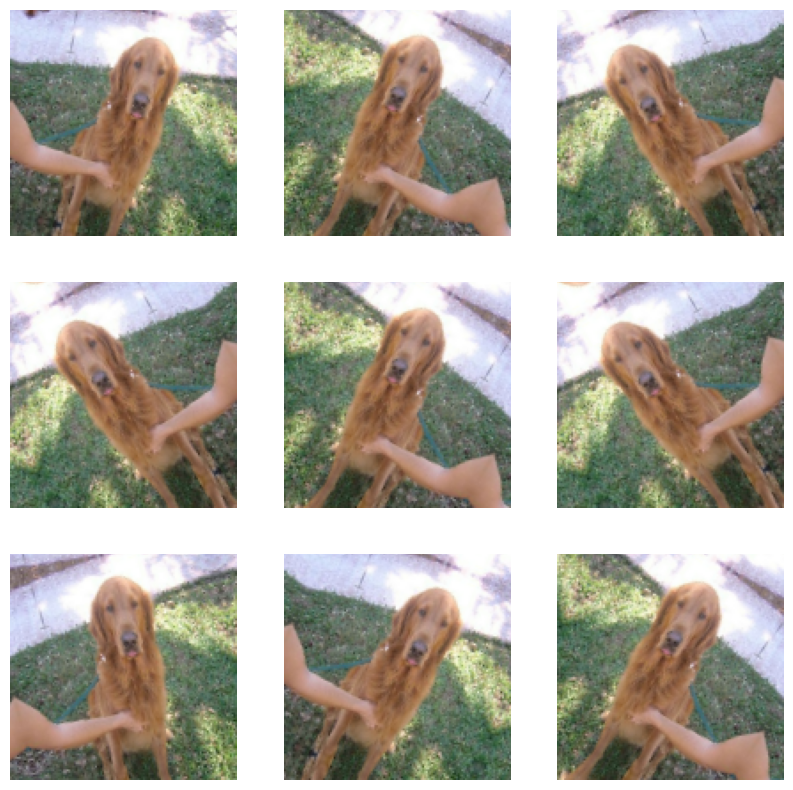

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Build a model

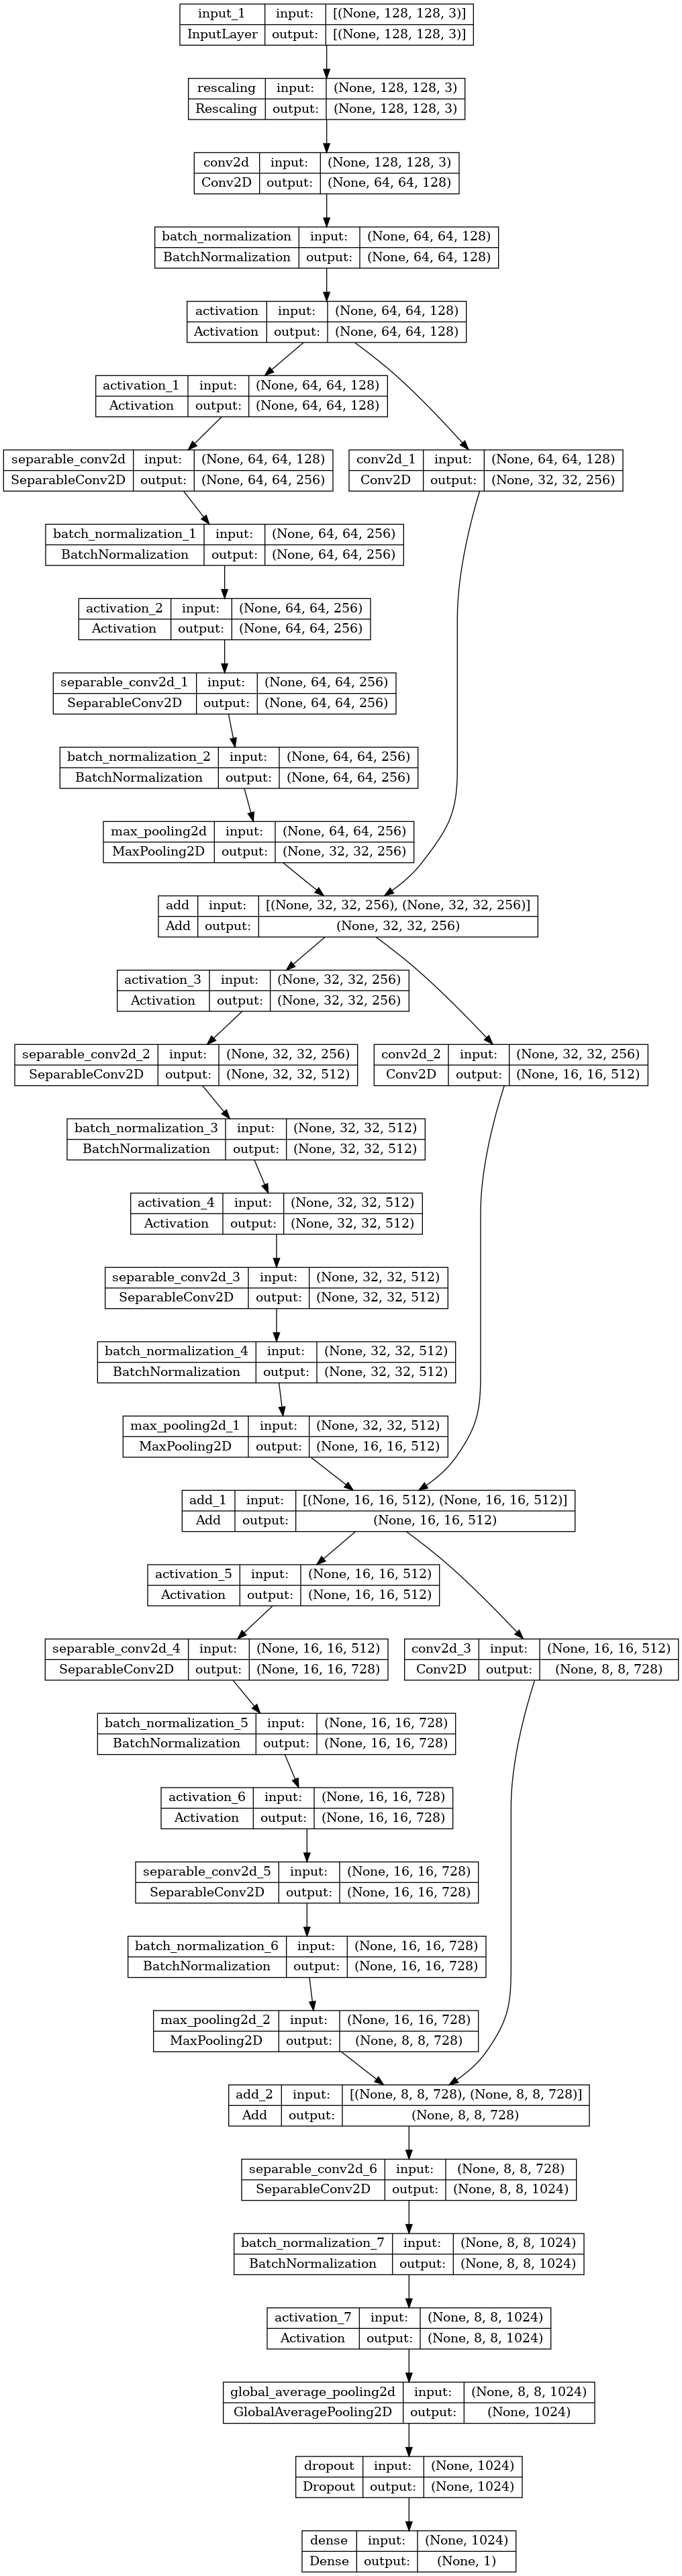

In [14]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = tf.keras.layers.Activation("gelu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("gelu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)


model = make_model(input_shape=CFG.IMAGE_SIZE + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

# Train

In [15]:
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=5, verbose=1, mode="auto")


# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=CFG.early_stopping_patience, restore_best_weights=True
)
callbacks = [
    reduceLROnPlat,
    early_stopping,
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(CFG.LR),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=CFG.epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/1000
147/147 [==============================] - 52s 314ms/step - loss: 0.6140 - accuracy: 0.6631 - val_loss: 0.6964 - val_accuracy: 0.4934 - lr: 1.3000e-04
Epoch 2/1000
147/147 [==============================] - 47s 313ms/step - loss: 0.5249 - accuracy: 0.7428 - val_loss: 0.7156 - val_accuracy: 0.4934 - lr: 1.3000e-04
Epoch 3/1000
147/147 [==============================] - 46s 312ms/step - loss: 0.4404 - accuracy: 0.7965 - val_loss: 0.7244 - val_accuracy: 0.4934 - lr: 1.3000e-04
Epoch 4/1000
147/147 [==============================] - 46s 312ms/step - loss: 0.4022 - accuracy: 0.8166 - val_loss: 0.7285 - val_accuracy: 0.4955 - lr: 1.3000e-04
Epoch 5/1000
147/147 [==============================] - 46s 311ms/step - loss: 0.3499 - accuracy: 0.8462 - val_loss: 1.0098 - val_accuracy: 0.5346 - lr: 1.3000e-04
Epoch 6/1000
147/147 [==============================] - 46s 311ms/step - loss: 0.3168 - accuracy: 0.8623 - val_loss: 0.2989 - val_accuracy: 0.8716 - lr: 1.3000e-04
Epoch 7/1000
147

Epoch 47/1000
147/147 [==============================] - 46s 311ms/step - loss: 0.0509 - accuracy: 0.9805 - val_loss: 0.1674 - val_accuracy: 0.9434 - lr: 8.5293e-05
Epoch 48/1000
147/147 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9833
Epoch 48: ReduceLROnPlateau reducing learning rate to 7.676370223634877e-05.
147/147 [==============================] - 46s 311ms/step - loss: 0.0464 - accuracy: 0.9833 - val_loss: 0.2831 - val_accuracy: 0.9084 - lr: 8.5293e-05
Epoch 49/1000
147/147 [==============================] - 46s 311ms/step - loss: 0.0439 - accuracy: 0.9837 - val_loss: 0.1546 - val_accuracy: 0.9415 - lr: 7.6764e-05
Epoch 50/1000
147/147 [==============================] - 46s 311ms/step - loss: 0.0439 - accuracy: 0.9832 - val_loss: 0.1624 - val_accuracy: 0.9423 - lr: 7.6764e-05
Epoch 51/1000
147/147 [==============================] - 46s 311ms/step - loss: 0.0455 - accuracy: 0.9829 - val_loss: 0.1669 - val_accuracy: 0.9404 - lr: 7.6764e-05
Epoch 52/1000

# Run inference on new data

In [16]:
img = tf.keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=CFG.IMAGE_SIZE
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 137ms/step
This image is 99.43% cat and 0.57% dog.


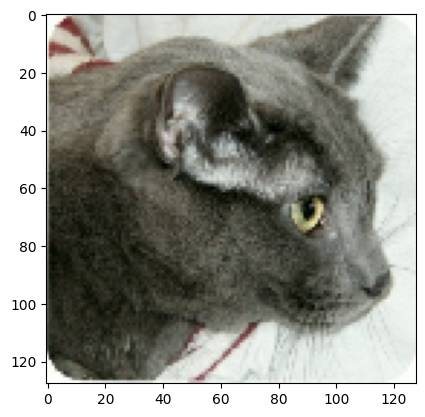

In [17]:
plt.imshow(img_array[0]/255)